## Summary


1.
   ***a) Describe the distribution that our daily transfer volumes follow.***

    A: Bimodal, right-skewed distribution
    
   ***b) What real-world cause do you think is behind this shape of distribution?***

    A: Distinct customer Segments  - C2C (small transactions) and B2B (large transactions)
  
    
   ***c) What are some of the implications that this distribution would commonly have on analysis that you might do***

    A: A bimodal, right-skewed distribution in transaction data has several important implications for analysis:  

  
     * **Mean Discrepancy** - the average value of the distribution will overestimate the value of a typical transaction. Mean is higher than Median and Mode (Mean > Median > Mode).
     * **Standard Deviation** -  becomes less meaningful
     * **Segmentation necessity** - customer behavior is different in two segments (B2B, C2C), so I'll need to analyse two groups separately, and separate forecasting model may be required
     * **Outlier handling decisions** - the right tail means there are few transactions with high value, so we need to decide if drop them
     * **Statistical testing limitations** - many parametric statistical tests assume normality, so we need to normalize (log, sqrt, or box-cox) the data before tests, as it may give misleading results. In skewed data is more appropriate non-parametric tests.
     * **Forecasting Complexity** - Simple time series models can struggle


.

2. ***Have transfer volumes along this route changed significantly from quarter to quarter in 2023?. How would you determine that the observed differences from quarter to quarter are 'real' as opposed to being the result of background fluctuations?***



   Yes, transfer volumes has changed significantly in Q3 (-15% in Q3 for higher group). There are two ways to determine that the observed differences are statistically significant:
  * Parametric tests: ANOVA (normalization is required, I used Box-Cox for transformation, Shapiro-Wilk test for normality, and Tukey’s HSD test to identify which specific pairs of quarters differ. The result of this test is that p = 0.009, which is less than 0.05, so I can reject the null hypothesis and conclude that there is a significant difference in the mean transaction amounts across the quarters. Q3 and Q4 have a statistically significant difference in transaction amounts. Q2 and Q3, and Q2 and Q4, do not show significant differences in transaction amounts.
)
   * Non-parametric tests: Kruskal-Wallis to check if the difference exists and Dunn’s test for pairwise comparisons Kruskal-Wallis.

   

3. ***Estimate the total transfer volume for October 2023***

   A: Estimated Transfer Volume in October 2023 is £6,422,863.89. During the data cleaning process, I noticed 22 missing dates, most of them in October. I found that missing dates are mainly working days. Given that I found the mean value of transactions by day name during the year and filled the missing data points. I can also estimate October's transaction volume based on the daily average of historical data as well as estimating confidence intervals. Based on this approach, **estimated Transfer Volume** in October 2023 is **£5,924,043.75** and **95% Confidence Interval** for October Total is **(£5,178,914.80, £6,669,172.71)**


    




### Import data and packages

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import copy
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
from scipy.stats import boxcox, yeojohnson

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Improve quality of graphs

In [57]:
raw_data = pd.read_csv('dataset.csv', parse_dates=True)
raw_data.head()

,posting_date,volume_gbp
0,2023-04-01,0.00
1,2023-04-02,170487.18
2,2023-04-03,250508.04
3,2023-04-04,611955.31
4,2023-04-05,282503.79


#### Functions

In [58]:
def find_valley_point(data, bins=100, smoothing_window=5):
    # Create histogram
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Smooth the histogram using moving average
    def smooth_histogram(hist, window_size):
        window = np.ones(window_size) / window_size
        return np.convolve(hist, window, mode='same')
    
    smoothed_hist = smooth_histogram(hist, smoothing_window)
    
    # Find peaks and valleys
    peak_indices = []
    valley_indices = []
    
    for i in range(1, len(smoothed_hist) - 1):
        if smoothed_hist[i] > smoothed_hist[i-1] and smoothed_hist[i] > smoothed_hist[i+1]:
            peak_indices.append(i)
        elif smoothed_hist[i] < smoothed_hist[i-1] and smoothed_hist[i] < smoothed_hist[i+1]:
            valley_indices.append(i)
    
    # Find the main valley between the two highest peaks
    if len(peak_indices) >= 2:
        # Get the two highest peaks
        peak_heights = [smoothed_hist[i] for i in peak_indices]
        sorted_peaks = sorted(zip(peak_heights, peak_indices), reverse=True)
        main_peaks = sorted(sorted_peaks[:2], key=lambda x: x[1])
        
        # Find valleys between these peaks
        valid_valleys = [v for v in valley_indices 
                        if v > main_peaks[0][1] and v < main_peaks[1][1]]
        
        if valid_valleys:
            valley_point = bin_centers[valid_valleys[0]]
        else:
            valley_point = None
    else:
        valley_point = None
    
    return valley_point, {
        'bin_centers': bin_centers,
        'hist': hist,
        'smoothed_hist': smoothed_hist,
        'peaks': peak_indices,
        'valleys': valley_indices
    }

def plot_distribution_with_valley(data, valley_point, hist_info):
    plt.figure(figsize=(12, 6))
    
    # Plot original histogram
    plt.hist(data, bins=100, density=True, alpha=0.5, color='gray', label='Original Data')
    
    # Plot smoothed histogram
    plt.plot(hist_info['bin_centers'], hist_info['smoothed_hist'], 
             'r-', linewidth=2, label='Smoothed Distribution')
    
    # Mark valley point
    if valley_point is not None:
        plt.axvline(x=valley_point, color='g', linestyle='--', 
                   label=f'Valley Point: {valley_point:.2f}')
    
    plt.title('Distribution with Valley Point')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    return plt

def split_distribution(data, plot=True):
    # Find valley point
    valley_point, hist_info = find_valley_point(dataset['volume_gbp'])
    
    # Split the data
    group1 = dataset['volume_gbp'][dataset['volume_gbp'] <= valley_point]
    group2 = dataset['volume_gbp'][dataset['volume_gbp'] > valley_point]
    
    if plot:
        plot_distribution_with_valley(dataset['volume_gbp'], valley_point, hist_info)
        plt.show()
    
    return valley_point, group1, group2

In [59]:
def summary_table(df):
    group_summary = df.groupby(['quarter'])['volume_gbp_x'].sum().to_frame()
    group_summary.rename(columns={'volume_gbp_x': 'sum_volume_gbp'}, inplace=True)
    group_summary['avg_volume_gbp'] = df.groupby(['quarter'])['volume_gbp_x'].mean()
    group_summary['pct_change_volume_gbp'] = group_summary['sum_volume_gbp'].pct_change()*100
    return group_summary

In [60]:
def non_parametric_tests(df, alpha):
    # Perform Kruskal-Wallis H-test
    q2 = df[df['quarter']=='Q2']['volume_gbp_x']
    q3 = df[df['quarter']=='Q3']['volume_gbp_x']
    q4 = df[df['quarter']=='Q4']['volume_gbp_x']
    h_stat, p_value = stats.kruskal(q2, q3, q4)
    if p_value < alpha:
        result  = f'{p_value:.4f} is < than {alpha}, so we would reject the null hypothesis.\
        This means there is strong statistical evidence that there are significant differences in transaction volumes between quarters'
        # Perform Dunn’s test (pairwise comparisons
        dunn_results = sp.posthoc_dunn(
            pd.DataFrame(df[['volume_gbp_x', 'quarter']]), 
            val_col='volume_gbp_x', 
            group_col='quarter', 
            p_adjust='bonferroni' 
)

    
    else:
        result =f'{p_value:.4f} is < than {alpha}, so we would reject the null hypothesis.'
    return result, ("Dunn's Test Pairwise Comparisons:", dunn_results)


### Data Cleaning
In this section, I'll perform data cleaning and data preprocessing

In [61]:
# Make a copy of original dataset
data = copy.deepcopy(raw_data)

In [62]:
print(f'Shape of data: {data.shape[1]} columns, {data.shape[0]} rows')

Shape of data: 2 columns, 253 rows


Check data type of columns to potentially transform them to appropriate data type, verify presence of missing / null values

In [63]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   posting_date  253 non-null    object 
 1   volume_gbp    253 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.1+ KB


In [64]:
# Convert porting date to a date data type
data['posting_date'] = pd.to_datetime(data['posting_date'])

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   posting_date  253 non-null    datetime64[ns]
 1   volume_gbp    253 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.1 KB


In [66]:
# Check for duplicates
data.duplicated().sum()

0

After a quick look at the time series data I saw that the data follows a weekly pattern, so there is weekly seasonality.

I can see also a potential data issue in October 2023.

A spike in early May can be an outlier or a big business transaction

In [67]:
data.head(5)

,posting_date,volume_gbp
0,2023-04-01,0.00
1,2023-04-02,170487.18
2,2023-04-03,250508.04
3,2023-04-04,611955.31
4,2023-04-05,282503.79


Some of the records have volume_gbp is equal to 0. I'll check their quantity and randomness

In [68]:
print(f'Number of records where volume_gbp is equal to 0 is: {data[data['volume_gbp']==0.0]['volume_gbp'].count()}')

Number of records where volume_gbp is equal to 0 is: 10


Verify if all date records are in place, given the earlier observation about October's data issue

In [69]:
# Generate Date range
full_dates = pd.date_range(start=data.iloc[0,0], end=data.iloc[-1, 0]).to_frame()
full_dates.rename(columns={0: 'date'}, inplace=True)

In [70]:
# Merge Date Range into the main dataset
dataset = full_dates.merge(data, how='left', left_on='date', right_on='posting_date')
dataset.head()

,date,posting_date,volume_gbp
0,2023-04-01,2023-04-01,0.00
1,2023-04-02,2023-04-02,170487.18
2,2023-04-03,2023-04-03,250508.04
3,2023-04-04,2023-04-04,611955.31
4,2023-04-05,2023-04-05,282503.79


In [71]:
# Count missing dates
print(f'Number of missing date records are: {dataset[dataset['date']!= dataset['posting_date']].count().iloc[0]}')

Number of missing date records are: 22


In [72]:
# Data Preprocessing
dataset['day_name'] = dataset['date'].dt.day_name()
dataset['month_name'] = dataset['date'].dt.month_name()
dataset['quarter'] = dataset['date'].dt.quarter
# Improve readability of quarter data
quarter_mapping = {1: 'Q1', 2: 'Q2', 3:'Q3', 4:'Q4'}
dataset['quarter'] = dataset['quarter'].apply(lambda x: quarter_mapping[x])
dataset.head()

,date,posting_date,volume_gbp,day_name,month_name,quarter
0,2023-04-01,2023-04-01,0.00,Saturday,April,Q2
1,2023-04-02,2023-04-02,170487.18,Sunday,April,Q2
2,2023-04-03,2023-04-03,250508.04,Monday,April,Q2
3,2023-04-04,2023-04-04,611955.31,Tuesday,April,Q2
4,2023-04-05,2023-04-05,282503.79,Wednesday,April,Q2


In [73]:
dataset[dataset['date']!= dataset['posting_date']].groupby('day_name')['date'].count()

day_name
Friday       4
Monday       5
Thursday     4
Tuesday      5
Wednesday    4
Name: date, dtype: int64

Most of the missing values are during the working days. I decided to fill them with the average of transactions based on the day of the week 

In [74]:
def fill_the_mean(condition_col, target_col, value_to_be_inserted, df):
    
    new_target_var = []
    
    for x, y in zip(condition_col, target_col):
        if str(y).lower()=='nan' or  str(y).lower()=='none':
            y = round(value_to_be_inserted[x], 2) # take corresponding mean value
        new_target_var.append(y)
    new_target_var = pd.Series(new_target_var)
    df['volume_gbp'] = new_target_var        
    return df.head()

In [75]:
daily_avg_transaction = dataset.groupby(['day_name'])['volume_gbp'].mean()
daily_avg_transaction

day_name
Friday       144876.891143
Monday       278064.950882
Saturday       1965.951750
Sunday        82575.706000
Thursday     227477.732857
Tuesday      369035.046765
Wednesday    264933.717429
Name: volume_gbp, dtype: float64

I can see a pattern here during the weekend  there is lower transaction volumes

In [76]:
fill_the_mean(dataset['day_name'], dataset['volume_gbp'], daily_avg_transaction, dataset)

,date,posting_date,volume_gbp,day_name,month_name,quarter
0,2023-04-01,2023-04-01,0.00,Saturday,April,Q2
1,2023-04-02,2023-04-02,170487.18,Sunday,April,Q2
2,2023-04-03,2023-04-03,250508.04,Monday,April,Q2
3,2023-04-04,2023-04-04,611955.31,Tuesday,April,Q2
4,2023-04-05,2023-04-05,282503.79,Wednesday,April,Q2


Data is clean and ready for analysis

### Data Exploration and Distribution

In [77]:
dataset.head()

,date,posting_date,volume_gbp,day_name,month_name,quarter
0,2023-04-01,2023-04-01,0.00,Saturday,April,Q2
1,2023-04-02,2023-04-02,170487.18,Sunday,April,Q2
2,2023-04-03,2023-04-03,250508.04,Monday,April,Q2
3,2023-04-04,2023-04-04,611955.31,Tuesday,April,Q2
4,2023-04-05,2023-04-05,282503.79,Wednesday,April,Q2


In [78]:
dataset.shape

(275, 6)

In [79]:
dataset[['volume_gbp']].describe().T

,count,mean,std,min,25%,50%,75%,max
volume_gbp,275.0,194446.587418,165193.009013,0.0,59669.51,182066.14,278258.08,1057540.77


<Axes: xlabel='day_name'>

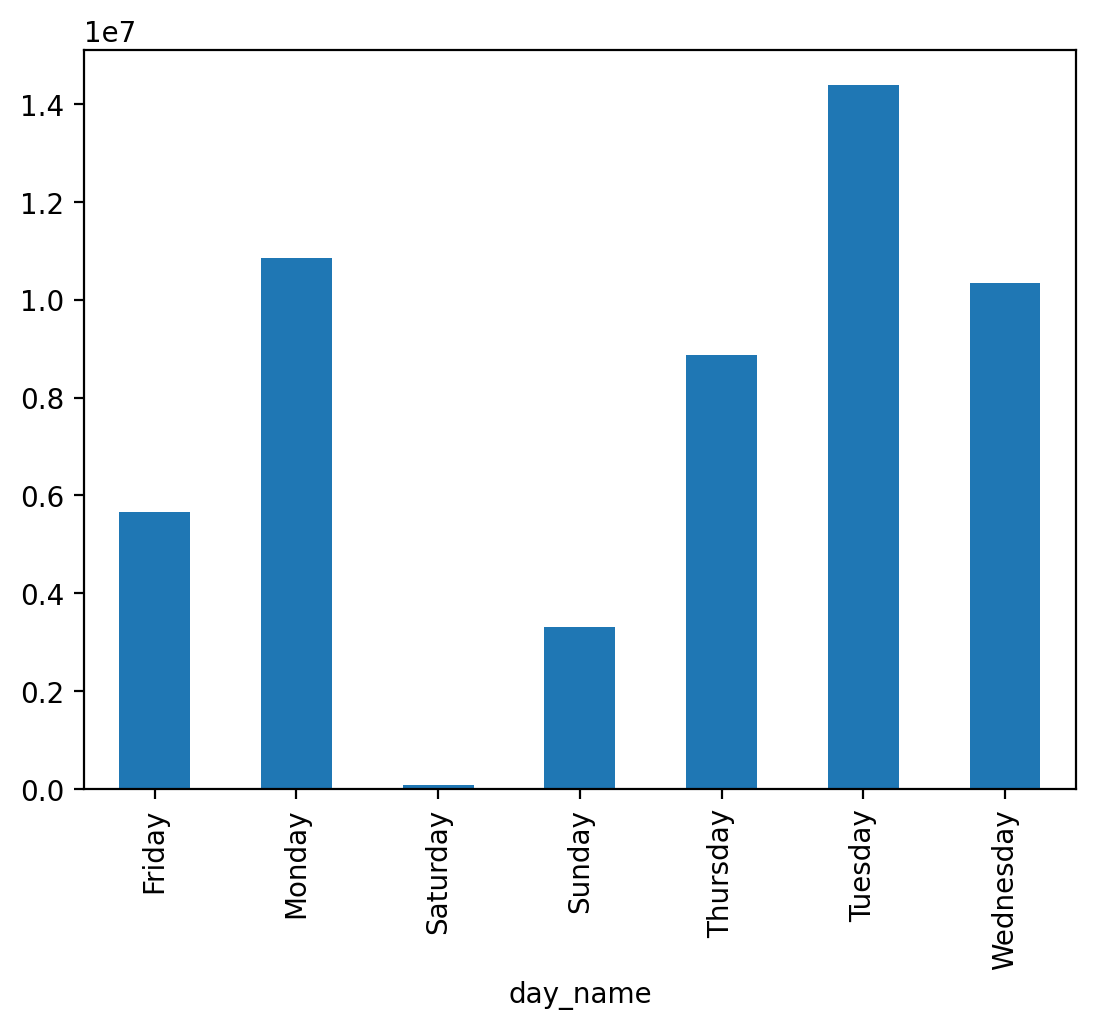

In [80]:
dataset.groupby('day_name')['volume_gbp'].sum().plot(kind='bar')
# Most of the missing values are during the working days

<Axes: title={'center': 'Transaction Volume'}, xlabel='date'>

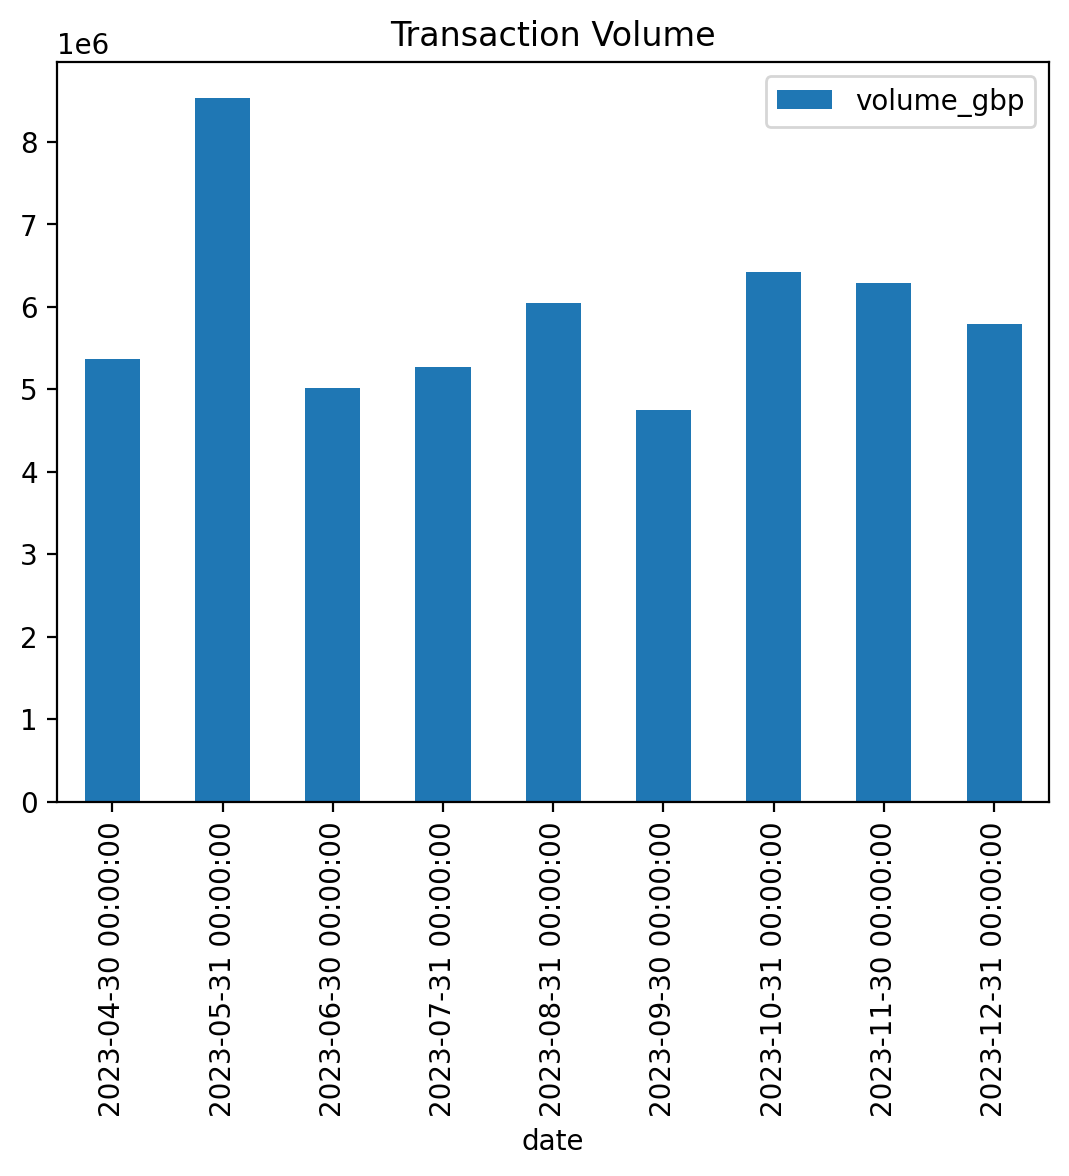

In [81]:
monthly_dataset  = pd.DataFrame(dataset[['date', 'volume_gbp']])
monthly_dataset.set_index('date', inplace=True)
monthly_dataset = monthly_dataset.resample('ME').sum()
monthly_dataset.plot(kind='bar', title='Transaction Volume')

In [82]:
fig = go.Figure(data=go.Scatter(x=data['posting_date'], y=data['volume_gbp']))
fig.show()

After a quick look at the time series data I saw that the data follows a weekly pattern, so there is weekly seasonality.

I can see also a potential data issue in October 2023.

A spike in early May can be an outlier or a big business transaction.

<Axes: xlabel='volume_gbp', ylabel='Density'>

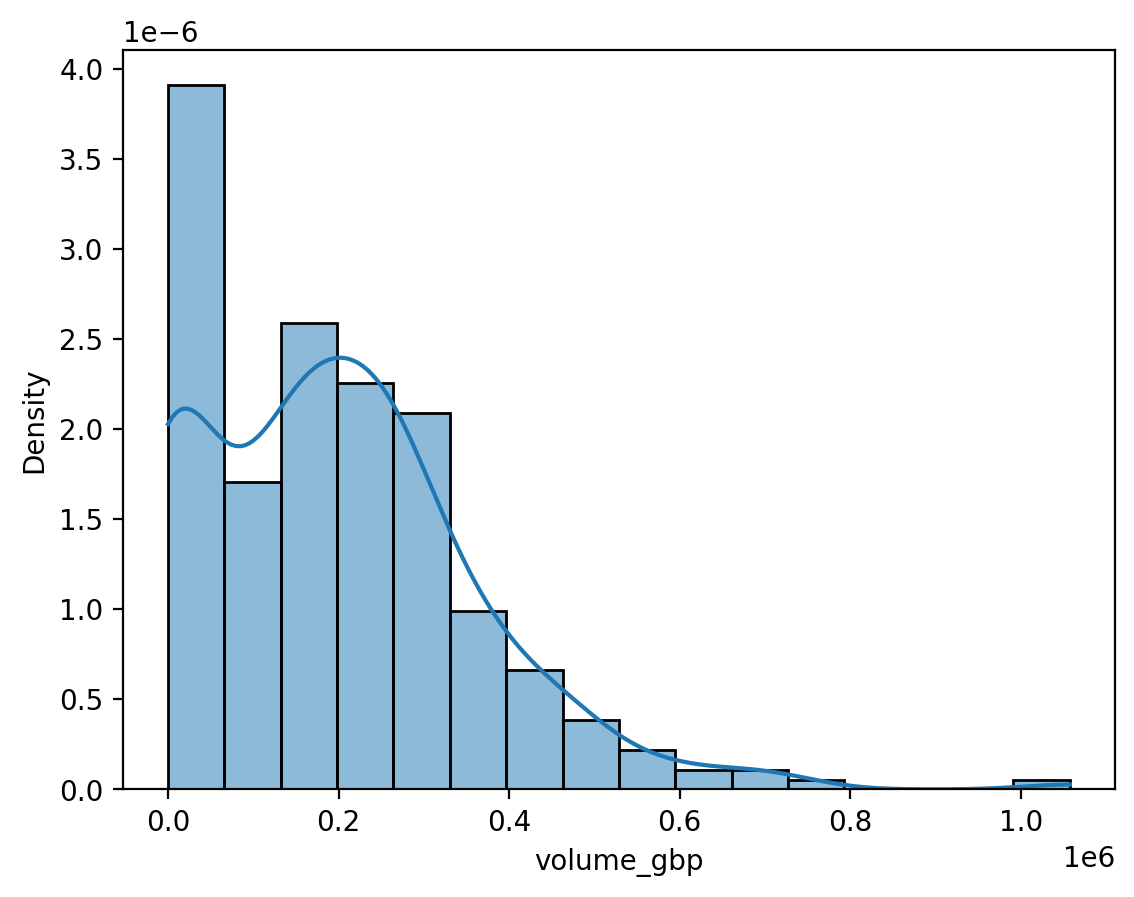

In [83]:
# Let's visualise the distribution
sns.histplot(dataset['volume_gbp'], kde=True, stat='density')

The chart shows that it is a bimodal, right-skewed distribution. Bimodal distribution can be justified by the presence of **two distinct customer segments**:
* Consumer to Consumer Transactions (C2C) - low value transactions
* Business to Business Transactions (B2B) - high value transactions

The distribution is skewed to the right, meaning most values are relatively low.
Given the implications (segmentation necessity) of bimodal right-skewed distribution, 

I'll proceed with splitting the distribution into two different groups using the Valley Point methodology, finding the local minimum between the two modes (the valley) and  using it as a splitting point. 

I use this method because modes are clearly separated



In [84]:
print(f'Valley point is: £{round(find_valley_point(dataset['volume_gbp'])[0], 1)}')

Valley point is: £37013.9


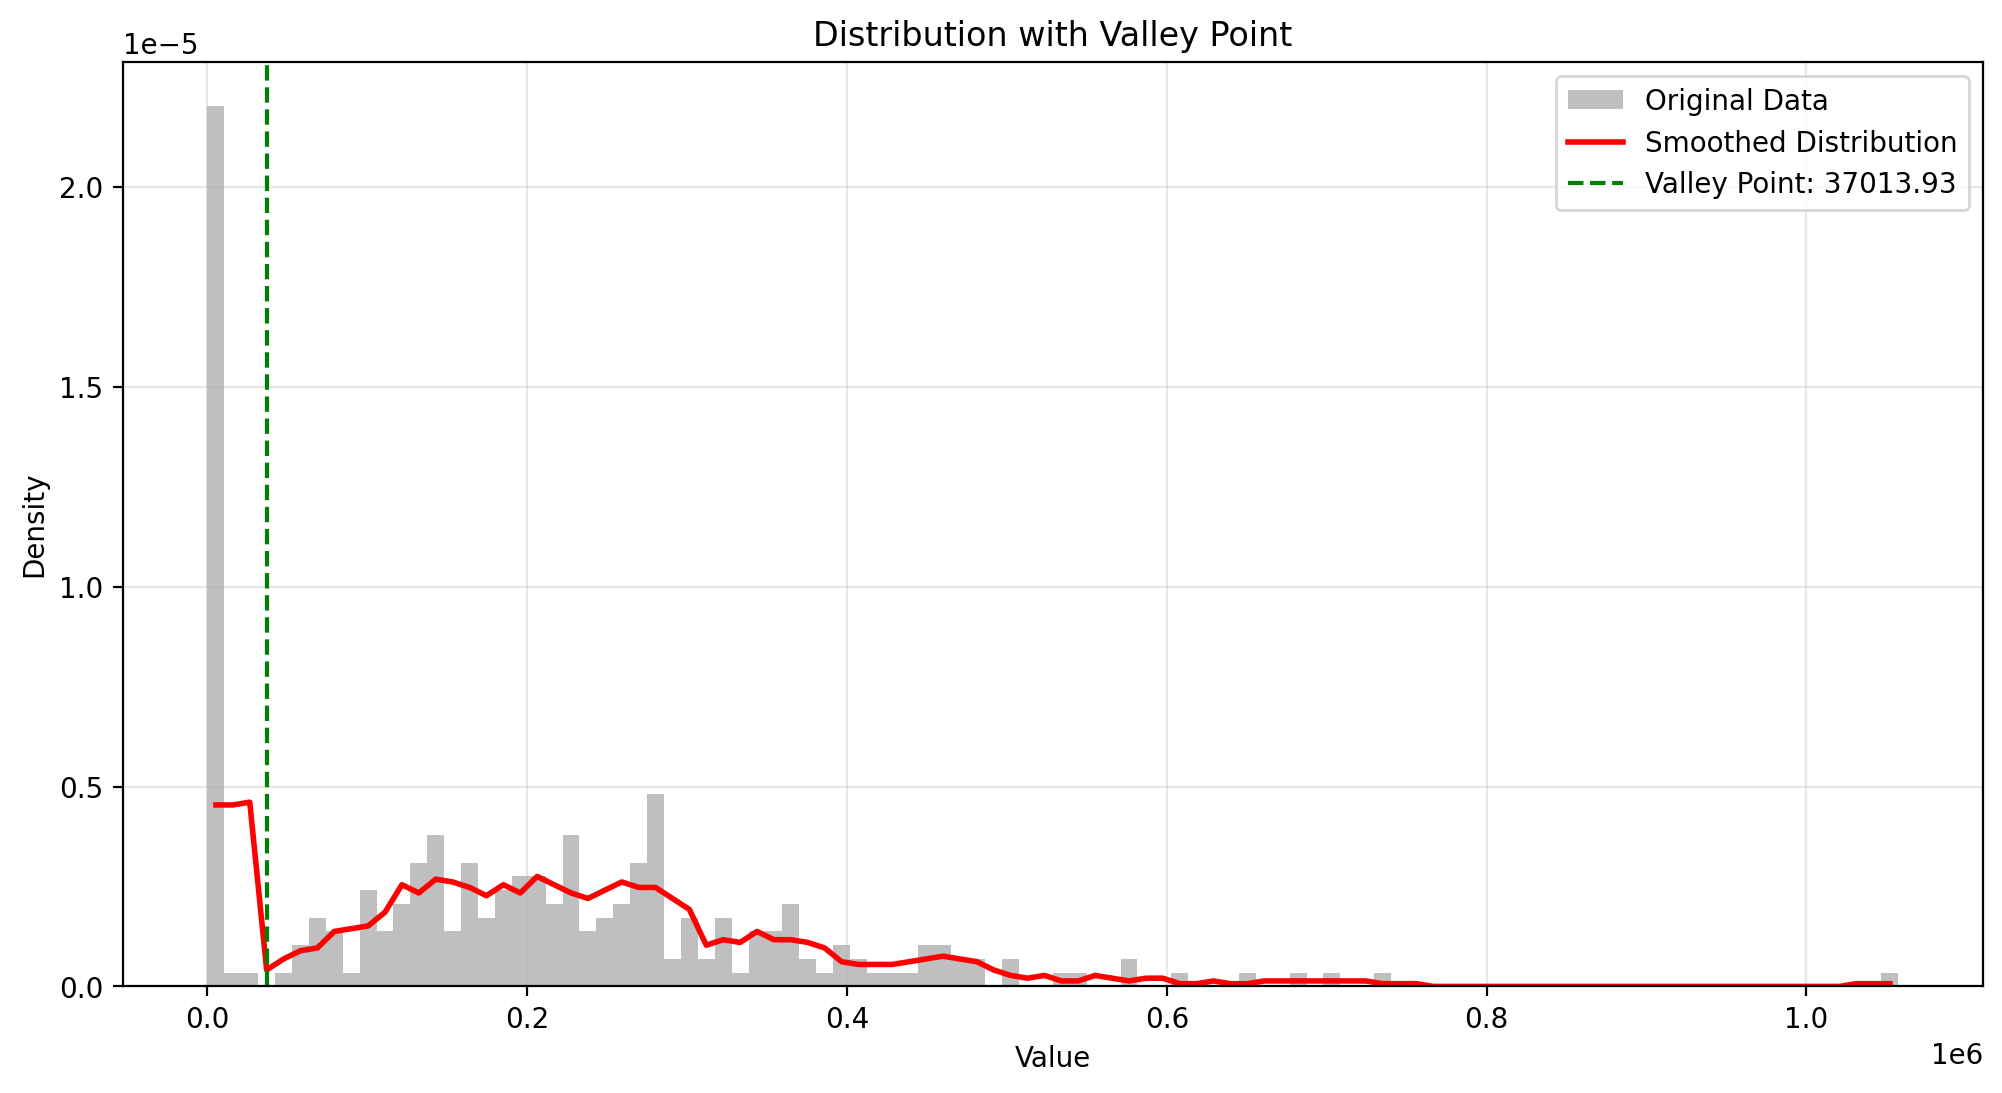

In [85]:
transaction_values = dataset['volume_gbp'].values
valley_point, lower_group, higher_group = split_distribution(transaction_values)

In [86]:
print(f'Valley point: {valley_point}')
print(f'Lower group size: {len(lower_group)} ({(len(lower_group)/dataset.shape[0]) * 100}%)')
print(f'Higher group size: {len(higher_group)} ({(len(higher_group)/dataset.shape[0]) * 100}%)')

Valley point: 37013.92695000002
Lower group size: 66 (24.0%)
Higher group size: 209 (76.0%)


[Text(0.5, 1.0, 'Lower Group Distribution')]

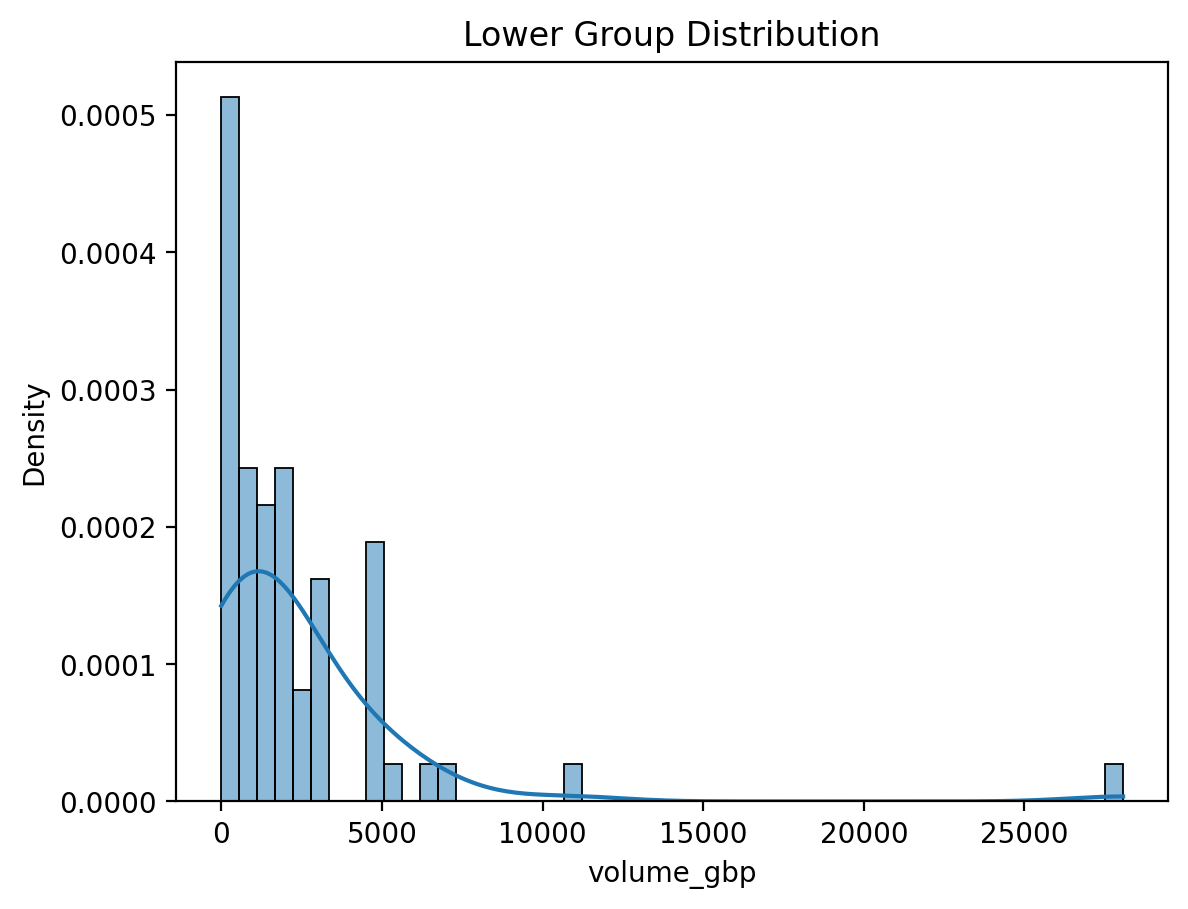

In [87]:
sns.histplot(dataset[dataset['volume_gbp']< 37013]['volume_gbp'], kde=True, stat="density", bins=50).set(title='Lower Group Distribution')

[Text(0.5, 1.0, 'Higher Group Distribution')]

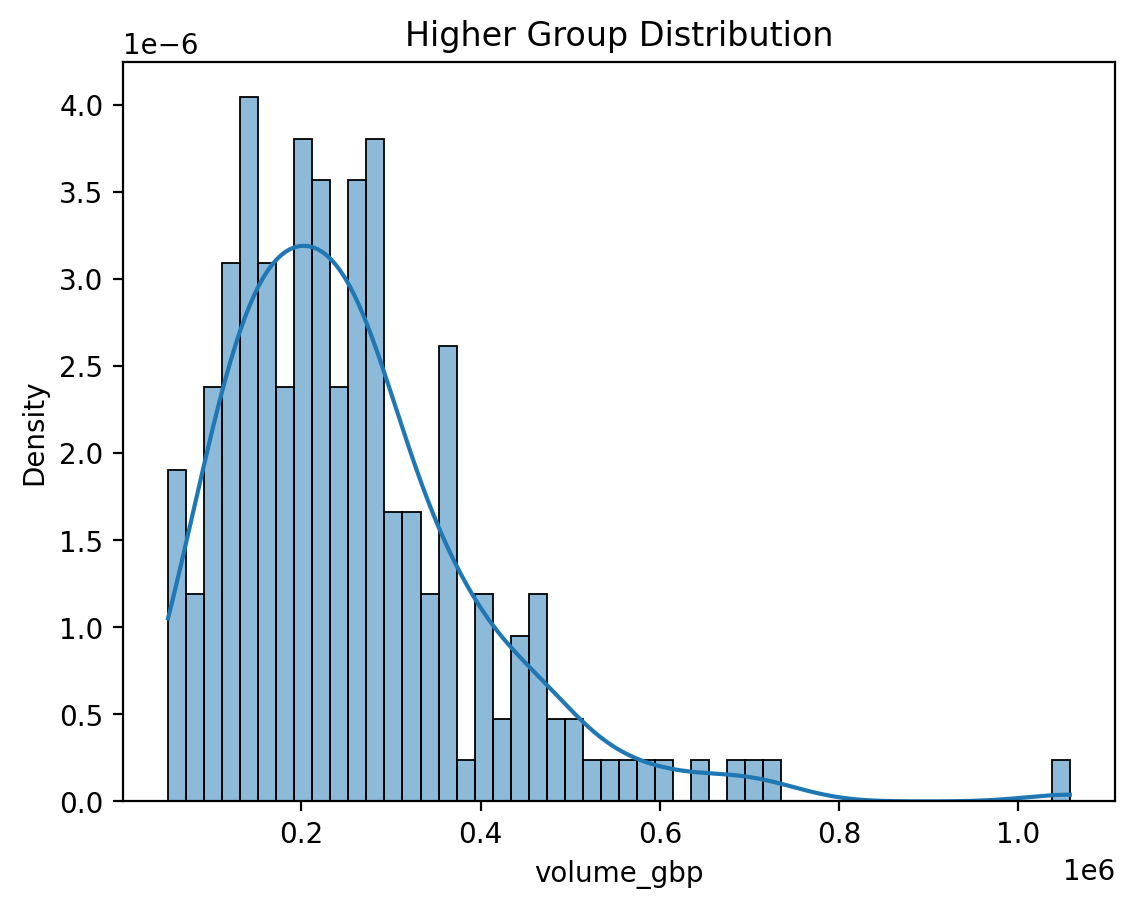

In [88]:
sns.histplot(dataset[dataset['volume_gbp']> 37000]['volume_gbp'], kde=True, stat="density", bins=50).set(title='Higher Group Distribution')

Both of the distribution are right skewed I'll analyse them separately

### Quarterly Data & Hypotesis Testing

#### Higher Group

In [89]:
higher_group_df = pd.DataFrame(higher_group)
# Merge original dataset to take quarter column
higher_group_df = higher_group_df.merge(dataset, how='left', left_index=True, right_index=True)
higher_group_df.drop(columns = ('volume_gbp_y'), inplace=True)
higher_group_df.head()

,volume_gbp_x,date,posting_date,day_name,month_name,quarter
1,170487.18,2023-04-02,2023-04-02,Sunday,April,Q2
2,250508.04,2023-04-03,2023-04-03,Monday,April,Q2
3,611955.31,2023-04-04,2023-04-04,Tuesday,April,Q2
4,282503.79,2023-04-05,2023-04-05,Wednesday,April,Q2
5,98214.34,2023-04-06,2023-04-06,Thursday,April,Q2


In [90]:
print('Higher Group Global Avg', round(higher_group_df['volume_gbp_x'].mean(), 2))

Higher Group Global Avg 255105.4


In [91]:
higher_group_summary = summary_table(higher_group_df)
higher_group_summary

,sum_volume_gbp,avg_volume_gbp,pct_change_volume_gbp
quarter,,,
Q2,18913303.64,266384.558310,NaN
Q3,15973665.11,215860.339324,-15.542703
Q4,18430059.27,287969.676094,15.377774


There is a difference between quarters, 15.54% down in Q3, and 15.38% up in Q4.

Let's test if it is statistically significant. To determine if these quarterly differences are statistically significant rather than random fluctuations,
we should perform statistical testing. I'll do it with both the Kruskal-Wallis test and ANOVA.

##### **Non Parametric test**
Methodology: Kruskal-Wallis test, Dunn’s test


Result: Non-Parametric test: p-value = 0.0007, there is a difference in transactions between quarters. Dunn’s test suggests that this difference is between Q3 and Q4.

In [92]:
# Kruskal-Wallis test
non_parametric_tests(higher_group_df, 0.05)

('0.0007 is < than 0.05, so we would reject the null hypothesis.        This means there is strong statistical evidence that there are significant differences in transaction volumes between quarters',
 ("Dunn's Test Pairwise Comparisons:",
            Q2        Q3        Q4
  Q2  1.000000  0.255362  0.100491
  Q3  0.255362  1.000000  0.000396
  Q4  0.100491  0.000396  1.000000))

There is strong statistical evidence to conclude that transaction volumes differ significantly between quarters.
The extremely low p-value (0.0007) suggests that the probability of observing such differences by chance, 
if no real difference existed, is less than 0.07%.

Kruskal-Wallis only tells us that a difference exists, so the next data to observe is Dunn's Test results to see which quarters differ. From the output table I can see that p-value < 0.05 is between Q3 and Q4. This means that the difference in transaction volumes is statistically significant

##### **Parametric test**
Methodology: ANOVA, Box-Cox normalisation, Shapiro-Wilk test, Levene’s test

Results: p-value = 0.009, there is a difference in transactions between quarters.Tukey’s HSD test suggests that this is between Q3 and Q4.

ANOVA Assumptions:
* Normality - Shapiro-Wilk test
* Homogeneity of variance - Levene’s test
* Independence

In [93]:
# let's normalise the distribution finding the best method (lower skewness)
np.sqrt(higher_group_df['volume_gbp_x']).skew()

0.6226227908798524

In [94]:
pd.Series(yeojohnson(higher_group_df['volume_gbp_x'])[0]).skew()

-0.0008882833297350517

In [95]:
higher_group_df['box_cox_normalised_volume'] = pd.Series(boxcox(higher_group_df['volume_gbp_x'])[0]).skew()

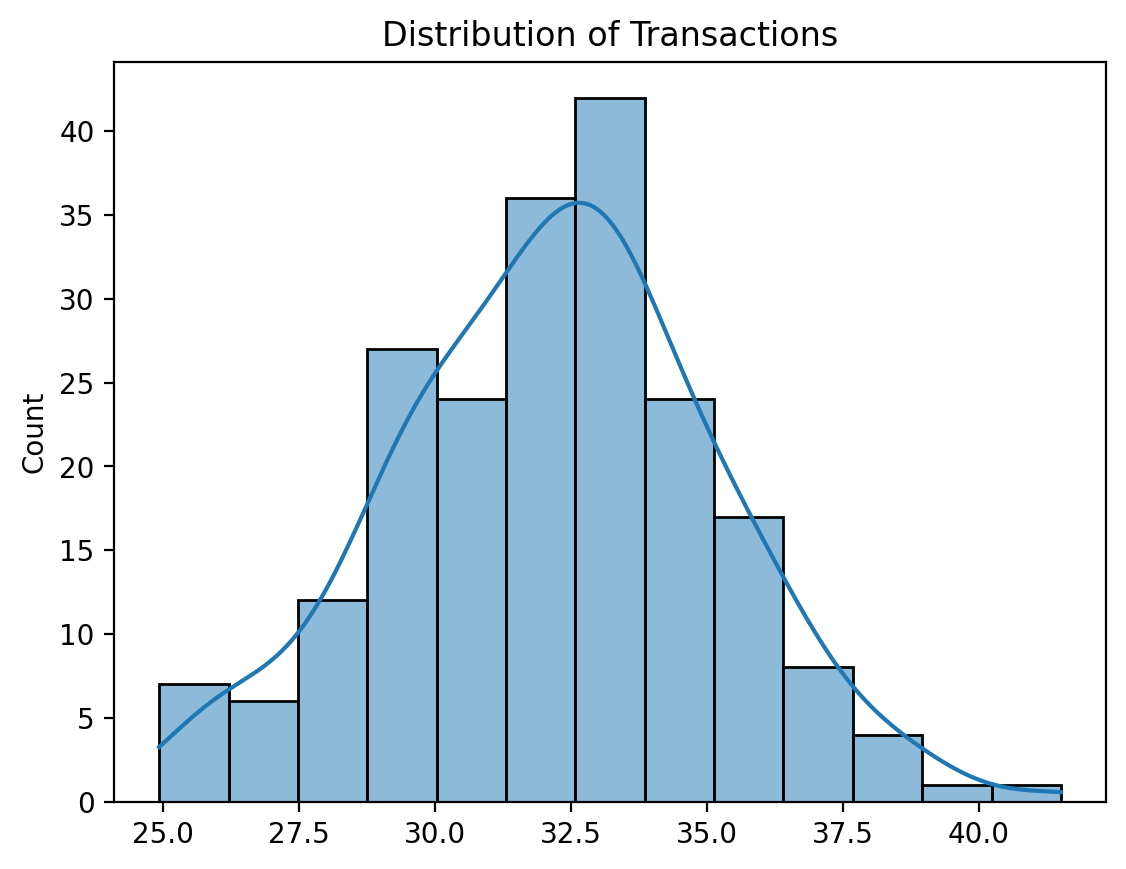

In [96]:
# Box Cox distribution normalisation seems to be the best
sns.histplot(boxcox(higher_group_df['volume_gbp_x'])[0], kde=True)
plt.title('Distribution of Transactions')
plt.show()

I'll check for normality using Shapiro-Wilk test. 

Hypothesis:
* H0 - The data is normally distributed
* H1 - The data is not normally distributed
* alpha = 0.05

In [97]:
# Shapiro-Wilk test
shapiro_test = stats.shapiro(boxcox(higher_group_df['volume_gbp_x'])[0])
print(f"Shapiro-Wilk p-value: {shapiro_test.pvalue}")

Shapiro-Wilk p-value: 0.7887965314209278


p-value > 0.05 this means that I cannot reject the null hypothesis. The data are normally distributed

In [98]:
# Levene’s test
groups = [group['volume_gbp_x'].values for _, group in higher_group_df.groupby('quarter')]
levene_stat, levene_p = stats.levene(*groups)
print(f"Levene’s Test Statistic: {levene_stat:.4f}, p-value: {levene_p:.4f}")

# Interpretation
if levene_p < 0.05:
    print('Variance is significantly different across quarters')
else:
    print('Variance is equal across quarters')

Levene’s Test Statistic: 2.2679, p-value: 0.1061
Variance is equal across quarters


ANOVA Hypothesis:
* H0 - The transaction mean for all quarters are equal
* H1 - At least one quarter has a significantly different mean
* Alpha = 0.05

In [99]:
F, p = stats.f_oneway(higher_group_df[higher_group_df['quarter']=='Q2']['volume_gbp_x']
                      ,higher_group_df[higher_group_df['quarter']=='Q3']['volume_gbp_x']
                     ,higher_group_df[higher_group_df['quarter']=='Q4']['volume_gbp_x'])
# Seeing if the overall model is significant
print('F-Statistic=%.3f, p=%.3f' % (F, p))

F-Statistic=4.851, p=0.009


Since p = 0.009, which is less than 0.05, I reject the null hypothesis and conclude that there is a significant difference in the mean transaction amounts across the quarters.

In [100]:
# Tukey’s HSD test
tukey = pairwise_tukeyhsd(higher_group_df['volume_gbp_x'], higher_group_df['quarter'], alpha=0.05)
    
print("\nTukey’s HSD Test Results:\n", tukey)


Tukey’s HSD Test Results:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2  meandiff  p-adj     lower        upper    reject
---------------------------------------------------------------
    Q2     Q3 -50524.219 0.0804 -105716.7487   4668.3107  False
    Q2     Q4 21585.1178 0.6473  -35679.8547  78850.0902  False
    Q3     Q4 72109.3368 0.0084   15397.3281 128821.3454   True
---------------------------------------------------------------


Summary
Q3 and Q4 have a statistically significant difference in transaction amounts.
Q2 and Q3, and Q2 and Q4, do not show significant differences in transaction amounts.

#### Lower Group

In [101]:
lower_group_df = pd.DataFrame(lower_group)
# Merge original dataset to take quarter column
lower_group_df = lower_group_df.merge(dataset, how='left', left_index=True, right_index=True)
lower_group_df.drop(columns = ('volume_gbp_y'), inplace=True)
lower_group_df = lower_group_df[['date', 'posting_date', 'volume_gbp_x', 'quarter']]
lower_group_df.head()

,date,posting_date,volume_gbp_x,quarter
0,2023-04-01,2023-04-01,0.00,Q2
6,2023-04-07,2023-04-07,0.00,Q2
7,2023-04-08,2023-04-08,133.93,Q2
8,2023-04-09,2023-04-09,0.00,Q2
14,2023-04-15,2023-04-15,1016.54,Q2


In [102]:
print('Lower Group Global Avg', round(lower_group_df['volume_gbp_x'].mean(), 2))

Lower Group Global Avg 2360.36


In [103]:
# Find quarterly volumes, average, and percentage change
lower_group_summary = summary_table(lower_group_df)
lower_group_summary

,sum_volume_gbp,avg_volume_gbp,pct_change_volume_gbp
quarter,,,
Q2,5906.32,295.316000,NaN
Q3,78092.88,4338.493333,1222.191822
Q4,71784.32,2563.725714,-8.078278


Hypotheses:

* **H₀ (Null)**: The distribution of transaction volumes is the same across quarters (no difference between quarters)
* **H₁ (Alternative)**: The distribution of transaction volumes differs between at least two quarters (at least one quarter has different transaction volumes)
* Significance level (**α**) = 0.05

In [104]:
# Kruskal-Wallis test
non_parametric_tests(lower_group_df, 0.05)

('0.0000 is < than 0.05, so we would reject the null hypothesis.        This means there is strong statistical evidence that there are significant differences in transaction volumes between quarters',
 ("Dunn's Test Pairwise Comparisons:",
            Q2        Q3        Q4
  Q2  1.000000  0.000003  0.000005
  Q3  0.000003  1.000000  1.000000
  Q4  0.000005  1.000000  1.000000))

Dunn's test suggests that there is statistically signinficant difference between transaction volumes in Q2/Q3 and Q2/Q4

### October 2023 Volume Estimation

During the data cleaning, I observed missing data points in October 2023.
I generated missing dates and filled missing the values with the average using day‐of‐week 
to reflect the true weekday activity, as most of the missing values were during the working days.

I can also estimate October's transaction volume based on the daily average of historical data as well as estimating confidence intervals.

In [105]:
monthly_dataset

,volume_gbp
date,
2023-04-30,5370905.52
2023-05-31,8535468.60
2023-06-30,5012835.84
2023-07-31,5268676.93
2023-08-31,6039546.69
2023-09-30,4743534.37
2023-10-31,6422863.89
2023-11-30,6286151.41
2023-12-31,5792828.29


<Axes: title={'center': 'Transaction Volumes'}, xlabel='date'>

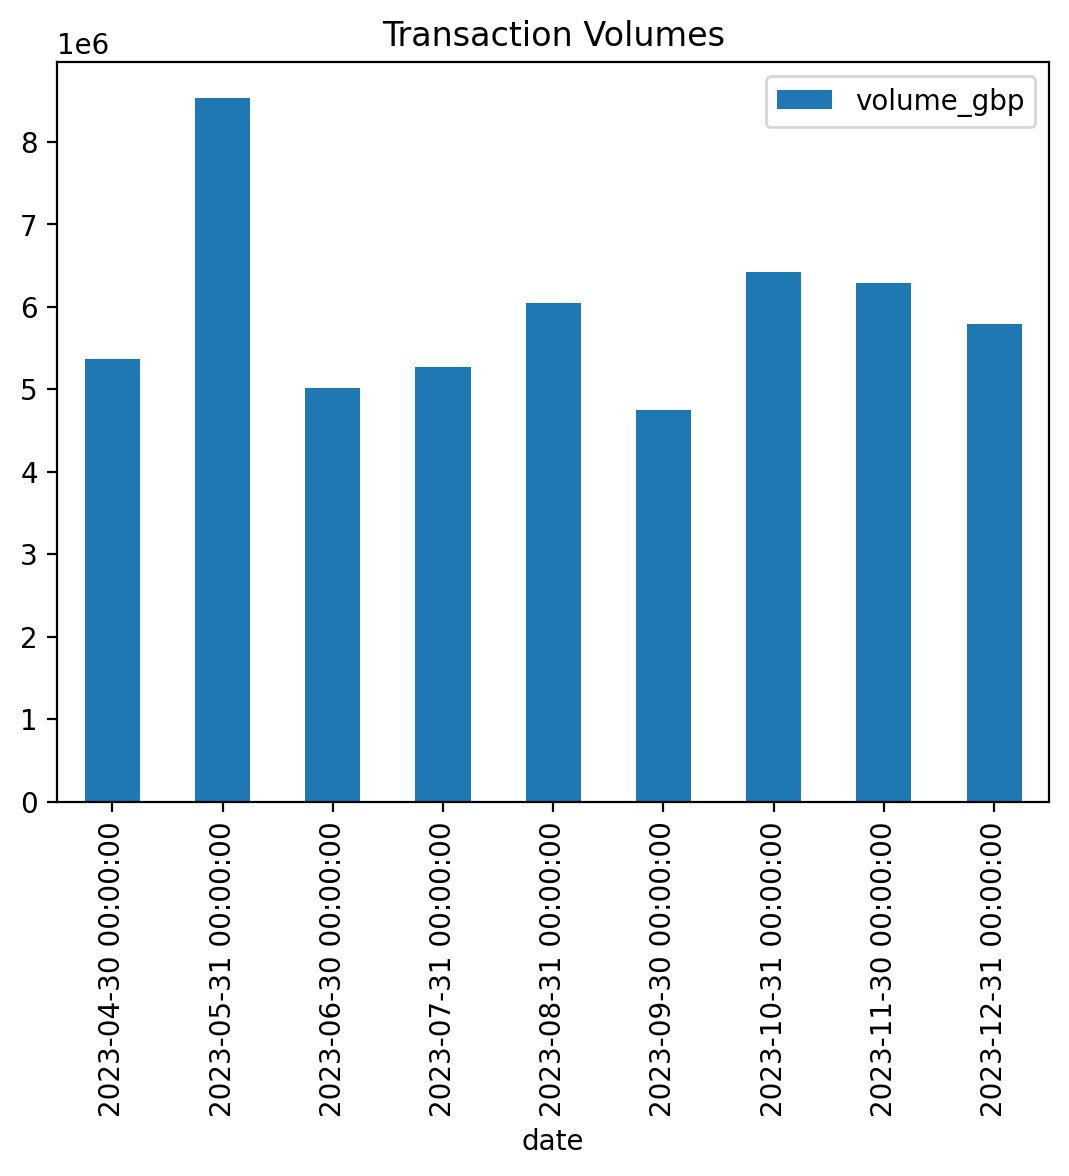

In [106]:
monthly_dataset.plot(kind='bar', title='Transaction Volumes')

In [107]:
# Take data from April to September to estimate October's transaction volume
apr_sept_data = dataset[(dataset['date'] >= '2023-04-01') & (dataset['date'] <= '2023-09-30')]

# Daily mean and standard deviation
daily_mean = apr_sept_data['volume_gbp'].mean()
daily_std = apr_sept_data['volume_gbp'].std()
n_records = apr_sept_data.shape[0]  # number of days from April to September
print('Historical Daily Mean: £{:,.2f}'.format(daily_mean))
print('Historical Daily Std Dev: £{:,.2f}'.format(daily_std))
print('Number of Historical Days:', n_records)

Historical Daily Mean: £191,098.19
Historical Daily Std Dev: £165,897.26
Number of Historical Days: 183


In [108]:
# If I assume the daily mean remains the same in October.
forecast_total = daily_mean * 31 

# Standard error (SE) of the daily mean
SE = daily_std / np.sqrt(n_records)

# Compute a 95% confidence interval for the daily mean
# (95% CI = mean ± 1.96 * SE)
lower_daily = daily_mean - 1.96 * SE
upper_daily = daily_mean + 1.96 * SE

# Project the daily CI to a monthly total
lower_total = lower_daily * 31
upper_total = upper_daily * 31

print('Forecasted Total for October 2023: £{:,.2f}'.format(forecast_total))
print('95% Confidence Interval for October Total: (£{:,.2f}, £{:,.2f})'.format(lower_total, upper_total))

Forecasted Total for October 2023: £5,924,043.75
95% Confidence Interval for October Total: (£5,178,914.80, £6,669,172.71)
